In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from google.colab import files
import pandas as pd
import io
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from google.colab import drive
import json
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import random
import tensorflow as tf
import cv2
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from sklearn.model_selection import train_test_split
import re
from functools import partial
import keras
from keras.layers import Dense, Dropout, Input, MaxPooling2D, ZeroPadding2D, Conv2D, Flatten, BatchNormalization
from keras.models import Sequential, Model
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, SGD
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from zipfile import ZipFile
import time
from datetime import timedelta
from io import BytesIO

# Image manipulation.
import PIL.Image

import pickle
import os

import random
from keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np

In [3]:
f = open('/content/drive/MyDrive/cassava-leaf-disease-classification/label_num_to_disease_map.json')
label_name = json.load(f)
label_name

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
Batch_Size = 32 * strategy.num_replicas_in_sync
Batch_Size

32

In [6]:
labels = list(label_name.keys())
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_path = '/content/drive/MyDrive/cassava-leaf-disease-classification/train_tfrecords/ld_train*.tfrec'
test_path = '/content/drive/MyDrive/cassava-leaf-disease-classification/test_tfrecords/ld_test*.tfrec'
Image_Size_Original = [512, 512]
image_size = 336

In [7]:
print(labels)

['0', '1', '2', '3', '4']


In [8]:
def preprocess_img(img):
  img_decode = tf.image.decode_jpeg(img, channels = 3)
  img_255 = tf.cast(img_decode, tf.float32)/255.0
  img_res = tf.image.resize(img_255, [image_size,image_size])
  img_resize = tf.reshape(img_res, [image_size, image_size,3])
  return img_resize

In [9]:
def read_tfrecord(example, labeled):
  tfrecord_format = {"image":tf.io.FixedLenFeature([], tf.string),
                     "target":tf.io.FixedLenFeature([], tf.int64),
                     } if labeled else {
                     "image": tf.io.FixedLenFeature([], tf.string),
                     "image_name": tf.io.FixedLenFeature([], tf.string)
                     }
  example = tf.io.parse_single_example(example, tfrecord_format)
  
  img_res = preprocess_img(example['image'])
  
  if labeled:
    label = tf.cast(example['target'], tf.int32)
    return img_res, label
  else: 
    id = example['image_name']
    return img_res, id

In [10]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

In [11]:
train_list = tf.io.gfile.glob(train_path)
test_list = tf.io.gfile.glob(test_path)
train_list, test_list

(['/content/drive/MyDrive/cassava-leaf-disease-classification/train_tfrecords/ld_train00-1338.tfrec',
  '/content/drive/MyDrive/cassava-leaf-disease-classification/train_tfrecords/ld_train01-1338.tfrec',
  '/content/drive/MyDrive/cassava-leaf-disease-classification/train_tfrecords/ld_train02-1338.tfrec',
  '/content/drive/MyDrive/cassava-leaf-disease-classification/train_tfrecords/ld_train03-1338.tfrec',
  '/content/drive/MyDrive/cassava-leaf-disease-classification/train_tfrecords/ld_train04-1338.tfrec',
  '/content/drive/MyDrive/cassava-leaf-disease-classification/train_tfrecords/ld_train05-1338.tfrec',
  '/content/drive/MyDrive/cassava-leaf-disease-classification/train_tfrecords/ld_train06-1338.tfrec',
  '/content/drive/MyDrive/cassava-leaf-disease-classification/train_tfrecords/ld_train07-1338.tfrec',
  '/content/drive/MyDrive/cassava-leaf-disease-classification/train_tfrecords/ld_train08-1338.tfrec',
  '/content/drive/MyDrive/cassava-leaf-disease-classification/train_tfrecords/ld_t

In [12]:
df_training, df_validation = train_test_split(train_list, test_size=0.2, random_state=2)
df_testing = tf.io.gfile.glob(test_list)

In [13]:
def train_augmentation(image, label):
    # image_augmentation 
    # image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_flip_up_down(image)
    # image = tf.image.random_hue(image, 0.2)
    # image = tf.image.random_crop(image,[image_size, image_size, 3])
    # image = tf.image.random_brightness(image, max_delta = 0.5)
    # image = tf.image.random_saturation(image, lower = 5, upper = 10)
    # image = tf.image.random_contrast(image, 0.2, 0.5)
    # image = tf.image.random_jpeg_quality(image, 75, 95)
    return image, label

In [14]:
def get_training_dataset():
    df_train = load_dataset(df_training, labeled=True)  
    df_train = df_train.map(train_augmentation, num_parallel_calls=AUTOTUNE)  
    df_train = df_train.repeat()
    df_train = df_train.shuffle(2048)
    df_train = df_train.batch(Batch_Size)
    df_train = df_train.prefetch(AUTOTUNE) 
    return df_train

In [15]:
def get_validation_dataset(ordered=False):
    df_valid = load_dataset(df_validation, labeled=True, ordered=ordered) 
    df_valid = df_valid.batch(Batch_Size)
    df_valid = df_valid.cache()
    df_valid = df_valid.prefetch(AUTOTUNE)
    return df_valid

In [16]:
def get_test_dataset(ordered=False):
    df_test = load_dataset(df_testing, labeled=False, ordered=ordered)
    df_test = df_test.batch(Batch_Size)
    df_test = df_test.prefetch(AUTOTUNE)
    return df_test

In [17]:
def counting(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [18]:
num_training = counting(df_training)
num_valid = counting(df_validation)
num_test = counting(df_testing)

# print('This Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
#     num_training, num_valid, num_test))

In [19]:
df_train = get_training_dataset()
df_valid = get_validation_dataset()
df_test = get_test_dataset()
# df_train, df_valid, df_test

In [20]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.2,0.2)),
  tf.keras.layers.experimental.preprocessing.RandomCrop(height = image_size, width = image_size) # 80%
  # tf.keras.layers.experimental.preprocessing.RandomHeight(factor=0.2),
  # tf.keras.layers.experimental.preprocessing.RandomWidth(factor=0.2),
  # tf.keras.layers.experimental.preprocessing.RandomContrast(0.25), try
  # tf.keras.layers.experimental.preprocessing.RandomZoom(0.5, 0.2)
])

In [21]:
def make_basemodel_1():
  base_model = tf.keras.applications.InceptionV3(input_shape=(image_size,image_size,3),
                                               include_top=False,
                                               weights='imagenet')
  for layer in base_model.layers:
    layer.trainble = False
  return base_model

base_model = make_basemodel_1()

87924736/87910968 [==============================] - 1s 0us/step


In [22]:
def make_headmodel_1(base_model):
  head = base_model.output

  head = tf.keras.layers.GlobalMaxPooling2D()(head)
  head = tf.keras.layers.BatchNormalization()(head)
  head = Dropout(0.3)(head)

  head = Flatten()(head)
  head = Dense(256, activation = "relu", kernel_regularizer = 'l2')(head)
  head = Dropout(0.5)(head)

  head = tf.keras.layers.Dense(5, activation = "softmax")(head)
  model = Model(inputs=base_model.input, outputs=head)
  return model

model = make_headmodel_1(base_model)

In [23]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = True)

model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [24]:
Batch_Size = 128
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history = model.fit(df_train,steps_per_epoch=steps_per_epoch, validation_data=df_valid, validation_steps=valid_steps, epochs=30)

Epoch 1/30
125/125 [==============================] - 223s 1s/step - loss: 6.4048 - accuracy: 0.4435 - val_loss: 5.5040 - val_accuracy: 0.6806
Epoch 2/30
125/125 [==============================] - 172s 1s/step - loss: 5.6298 - accuracy: 0.6033 - val_loss: 5.1275 - val_accuracy: 0.6845
Epoch 3/30
125/125 [==============================] - 172s 1s/step - loss: 5.1826 - accuracy: 0.6708 - val_loss: 4.8719 - val_accuracy: 0.7538
Epoch 4/30
125/125 [==============================] - 172s 1s/step - loss: 4.8302 - accuracy: 0.7163 - val_loss: 4.7148 - val_accuracy: 0.7774
Epoch 5/30
125/125 [==============================] - 172s 1s/step - loss: 4.5402 - accuracy: 0.7565 - val_loss: 4.3759 - val_accuracy: 0.7698
Epoch 6/30
125/125 [==============================] - 172s 1s/step - loss: 4.3574 - accuracy: 0.7560 - val_loss: 4.1328 - val_accuracy: 0.7995
Epoch 7/30
125/125 [==============================] - 172s 1s/step - loss: 4.0848 - accuracy: 0.7925 - val_loss: 4.0061 - val_accuracy: 0.7896

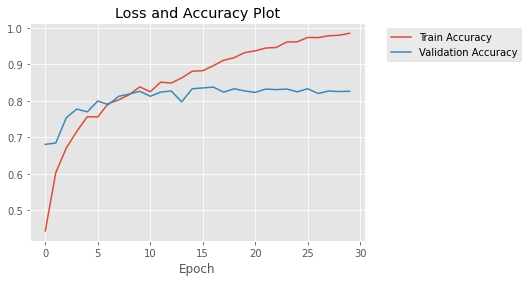

In [25]:
import matplotlib.pyplot as plt
import numpy as np

N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

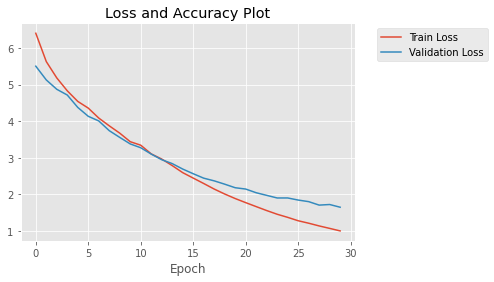

In [26]:
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')